# Preliminary Pulsar data analysis

In [1]:
library(tidyverse)
library(ggplot2)
library(dplyr) 
library(tidymodels)
install.packages("corrplot")
library(ggplot2)
library(GGally)
library(class)
library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## 1. import the data, tidy the data set, show summary statistics 

In [2]:
# import data
#temp  <- tempfile()
#download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip",temp)
pulsar <- read.csv("https://raw.githubusercontent.com/RowanYuwenLUO/dsci100_2022w1_group168/main/HTRU_2.csv",
                   header = FALSE, 
                   col.names = c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                                 "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness",
                                 "Class"))

In [3]:
# dimension of the data set
dim(pulsar) 

[1] 17898     9

- 17898 observations (rows)
- 9 variables (columns)

In [4]:
head(pulsar)

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
2,102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
3,103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
4,136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
5,88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
6,93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [5]:
# summary statistics for all 8 predictors
summary_table <- data.frame(cbind(summary(pulsar$integr.mean), summary(pulsar$integr.std),
                                  summary(pulsar$integr.kurtosis), summary(pulsar$integr.skewness),
                                  summary(pulsar$DMSNR.mean), summary(pulsar$DMSNR.std), 
                                  summary(pulsar$DMSNR.kurtosis), summary(pulsar$DMSNR.skewness))) 
colnames(summary_table) <- c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness")
summary_table

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,5.8125,24.77204,-1.87601118,-1.7918860,0.2132107,7.370432,-3.139270,-1.976976
1st Qu.,100.9297,42.37602,0.02709812,-0.1885717,1.9230769,14.437332,5.781506,34.960504
Median,115.0781,46.94748,0.22324002,0.1987104,2.8018395,18.461316,8.433515,83.064556
Mean,111.0800,46.54953,0.47785726,1.7702790,12.6143997,26.326515,8.303556,104.857709
3rd Qu.,127.0859,51.02320,0.47332518,0.9277831,5.4642559,28.428104,10.702959,139.309330
Max.,192.6172,98.77891,8.06952205,68.1016217,223.3921405,110.642211,34.539844,1191.000837


In [6]:
# check the missing data
sum(is.na(pulsar))

[1] 0

- no missing data here

In [7]:
# show number of observations in each class
count_data <- pulsar %>% 
    group_by(Class) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / nrow(pulsar))
count_data 

Class,n,freq
<int>,<int>,<dbl>
0,16259,0.90842552
1,1639,0.09157448


- `0 is the negative examples`
- `1 is the positive examples`
- majority of the data (around 90%) are in class 0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



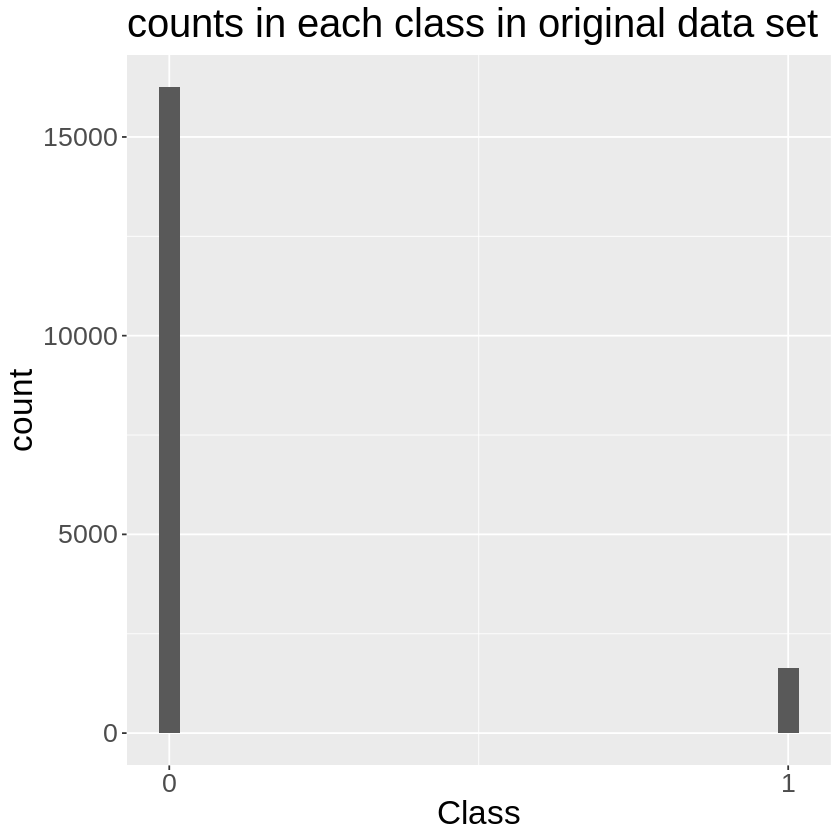

In [8]:
# display the distribution using histogram
ggplot() + 
  geom_histogram(pulsar, mapping = aes(Class)) + 
  ggtitle("counts in each class in original data set") + 
  scale_x_continuous(breaks = 0:1) + 
  theme(text = element_text(size=20)) 

## 2. split the data into training and testing sets

In [9]:
set.seed(123)
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

In [10]:
# dimension of the training data set 
dim(pulsar_train) 

[1] 13423     9

In [11]:
# number of observations in each class
count_train <- pulsar_train %>% 
    group_by(Class) %>% 
    summarise(n=n()) %>%
    mutate(freq = n / nrow(pulsar_train))
count_train

Class,n,freq
<int>,<int>,<dbl>
0,12170,0.90665276
1,1253,0.09334724


In [12]:
# compare the data size with original data set
cbind(original = count_data, train = count_train)

original.Class,original.n,original.freq,train.Class,train.n,train.freq
<int>,<int>,<dbl>,<int>,<int>,<dbl>
0,16259,0.90842552,0,12170,0.90665276
1,1639,0.09157448,1,1253,0.09334724


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



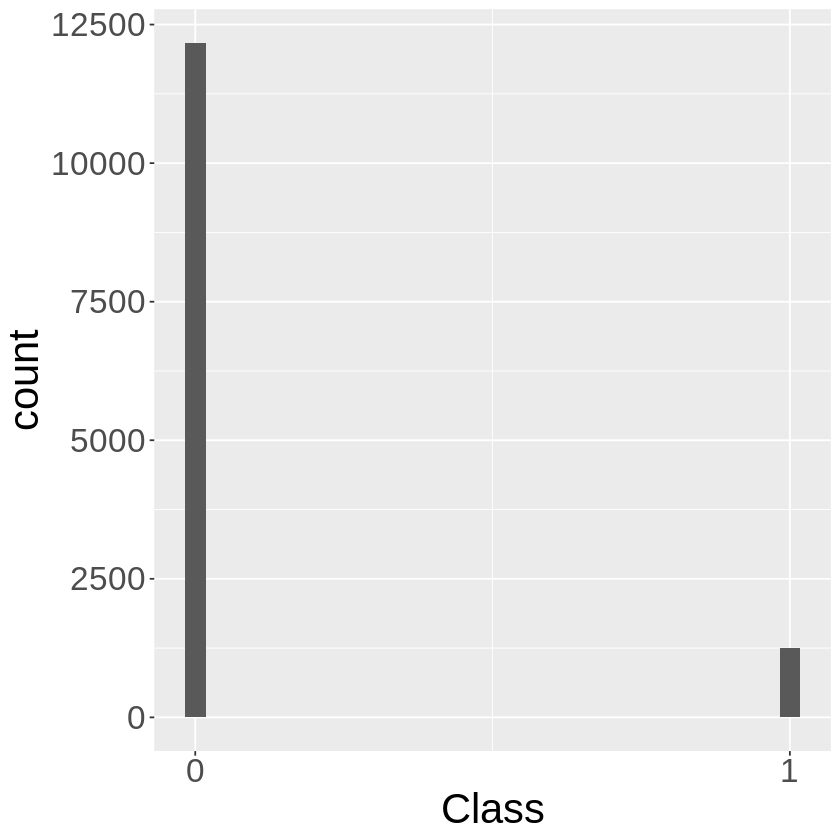

In [13]:
# display the distribution in training set using histogram
ggplot() + 
  geom_histogram(pulsar_train, mapping = aes(Class)) + 
  scale_x_continuous(breaks = 0:1) + 
  theme(text = element_text(size=25)) 

- training data set show the almost same proportion as the original dataset

## 3. Sample down the `0 (negative) class` in the training set: to deal with the imbalancing probelm.
### - let the number of data belongs to class 0 = the number of data belongs to class 1
### - so that proportion for the two classes are the same, equals to 0.5

In [14]:
set.seed(123)
train_c1 <- filter(pulsar_train, Class == 1)
train_c0 <- filter(pulsar_train, Class == 0)

sample_down_train <- pulsar_train %>% 
  filter(Class ==0) %>%
  sample_n(nrow(train_c1)) %>%
  rbind(train_c1)

In [15]:
# dimension for the training data after sampling down
dim(sample_down_train)

[1] 2506    9

- 2506 observations
- 9 variables

### now use the training set after sampling down to do the analysis !

In [16]:
# calculate the means of the predictor variables
predictors_mean <- sample_down_train %>% 
  select(-Class) %>% 
  colMeans() %>%
  data.frame()
colnames(predictors_mean) <- "mean"
predictors_mean

,mean
,<dbl>
integr.mean,86.256958
integr.std,42.861345
integr.kurtosis,1.700721
integr.skewness,8.177292
DMSNR.mean,29.887667
DMSNR.std,40.028187
DMSNR.kurtosis,5.824315
DMSNR.skewness,67.323829


#### large differences between the mean of these predictors:
the largest one is about 86, while the smallest one is only 1.7


## 4. Scale the training set after sampling down

In [17]:
all_predictors_name <- colnames(sample_down_train[, 1:8])

scaled_train <- sample_down_train %>% 
  mutate_at(all_predictors_name, ~(scale(.) %>% as.vector))

In [18]:
train_summary_table <- data.frame(cbind(summary(scaled_train$integr.mean), summary(scaled_train$integr.std),
                                  summary(scaled_train$integr.kurtosis), summary(scaled_train$integr.skewness),
                                  summary(scaled_train$DMSNR.mean), summary(scaled_train$DMSNR.std), 
                                  summary(scaled_train$DMSNR.kurtosis), summary(scaled_train$DMSNR.skewness))) 
colnames(train_summary_table) <- c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness")
train_summary_table

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,-2.063690e+00,-2.167562e+00,-1.713450e+00,-7.536754e-01,-6.980701e-01,-1.310994e+00,-1.723480e+00,-6.851254e-01
1st Qu.,-8.460459e-01,-8.084394e-01,-7.530860e-01,-6.354165e-01,-6.467820e-01,-9.281084e-01,-8.585520e-01,-6.502978e-01
Median,2.374179e-01,4.664097e-02,-5.150877e-01,-5.389346e-01,-5.436098e-01,-3.045725e-01,-1.336230e-01,-3.934826e-01
Mean,1.698600e-16,3.169741e-16,1.794415e-17,-3.234156e-17,-1.430887e-17,-1.394447e-16,6.247955e-17,-9.230731e-18
3rd Qu.,8.099643e-01,7.350632e-01,6.425342e-01,2.861652e-01,2.393543e-01,9.147824e-01,6.931118e-01,3.099548e-01
Max.,2.539729e+00,4.905129e+00,3.173435e+00,4.711405e+00,4.163813e+00,2.722087e+00,5.372250e+00,9.950703e+00


In [19]:
scaled_predictors_mean <- scaled_train %>% 
  select(-Class) %>% 
  colMeans() %>%
  data.frame()
colnames(scaled_predictors_mean) <- "mean"
scaled_predictors_mean

,mean
,<dbl>
integr.mean,1.686572e-16
integr.std,3.168992e-16
integr.kurtosis,1.484137e-17
integr.skewness,-3.649426e-17
DMSNR.mean,-1.664808e-17
DMSNR.std,-1.331459e-16
DMSNR.kurtosis,5.974620e-17
DMSNR.skewness,-7.091184e-18


#### After scaling the predictos in thetraining set, every predictor has mean around 0.

In [20]:
head(scaled_train)

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.9530132,1.8106637,-0.8168831,-0.7010886,-0.6561685,-1.0755796,0.89087155,0.7126506,0
2,1.0886967,3.6593985,-0.8675785,-0.7536754,1.5101584,1.5944108,-1.15877415,-0.6803251,0
3,1.3450323,0.5883488,-1.0096455,-0.6209852,-0.6637171,-1.0960985,1.17488947,1.0446210,0
4,0.7439764,1.0821099,-0.6363887,-0.6296116,-0.3042426,0.5808810,-0.59015834,-0.5998106,0
5,0.8339644,-0.0828916,-0.6085113,-0.5989493,-0.5693893,-0.3795561,-0.00139643,-0.3265444,0
6,-0.1064005,-0.6559463,-0.4430658,-0.4385813,-0.6034269,-0.5059058,0.22646530,-0.1780283,0


## 5. visualize the training set

In [21]:
pivot_train <- scaled_train %>%
  pivot_longer(cols = integr.mean:DMSNR.skewness,
               names_to = "predictor", 
               values_to = "value")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



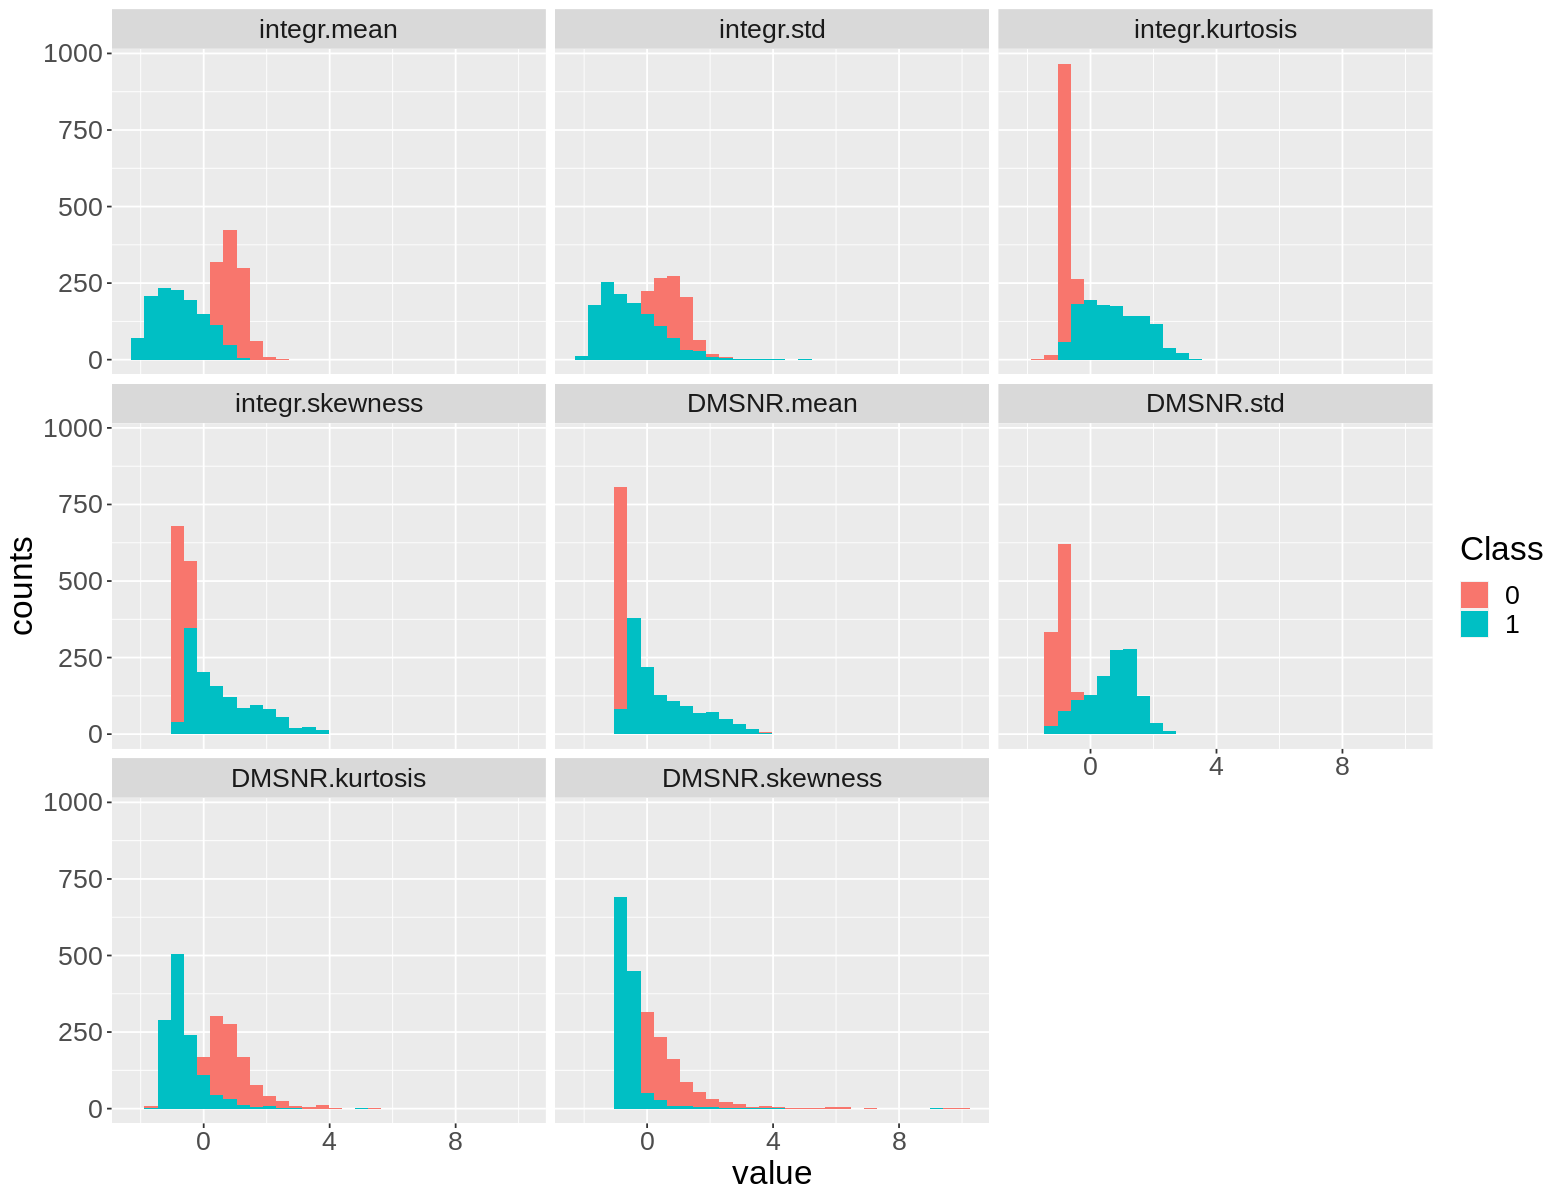

In [22]:
# histogram for all 8 variables
options(repr.plot.width = 13, repr.plot.height = 10) 

pivot_train %>% 
  ggplot(aes(x = value, fill = as.factor(Class))) + 
  geom_histogram(position = "identity") + 
  facet_wrap(~ factor(predictor, 
                      levels = c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                                 "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness"))) +
  xlab("value") + 
  ylab("counts") + 
  labs(fill = "Class") +
  theme(text = element_text(size=20)) 

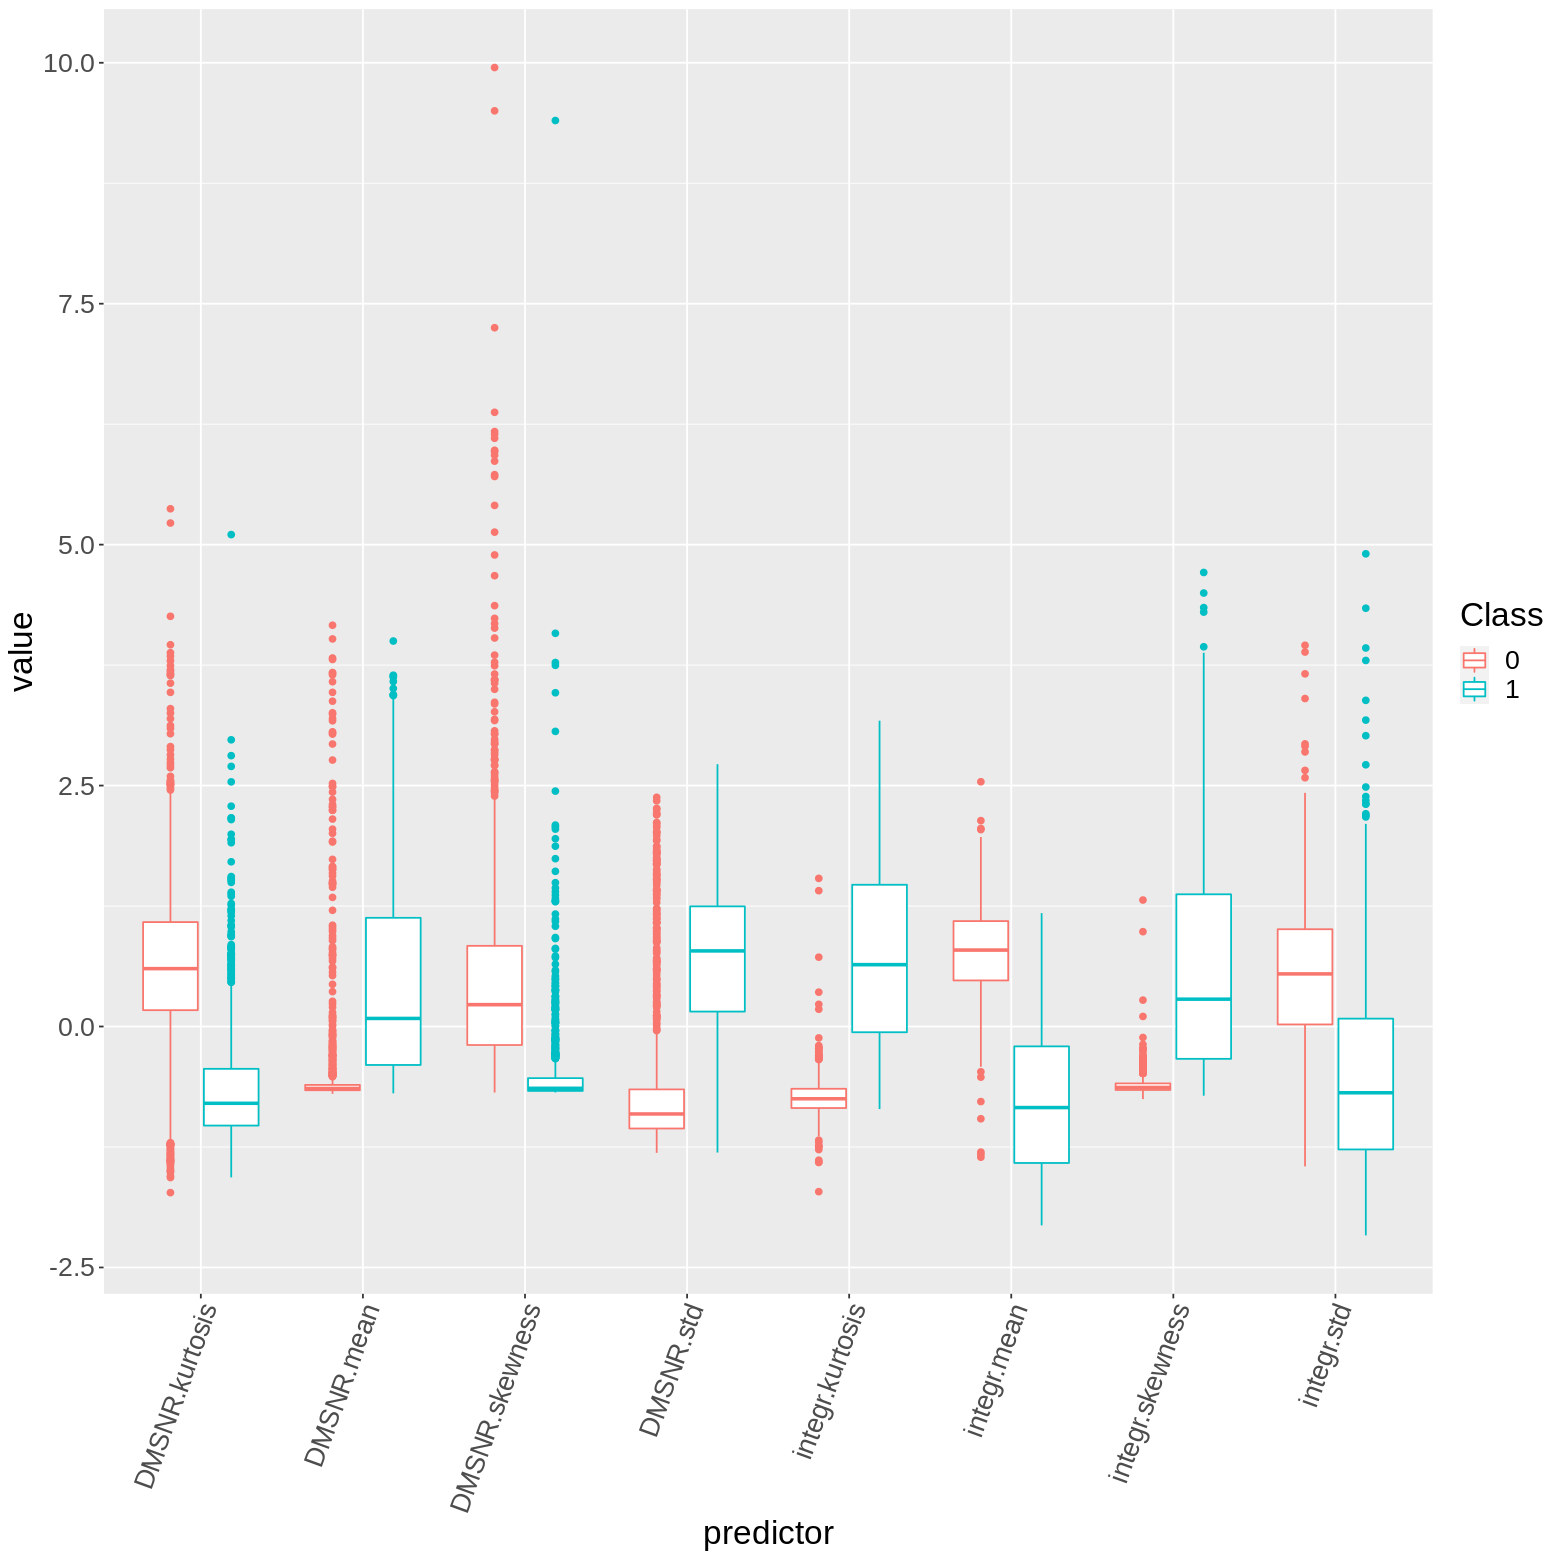

In [23]:
# boxplot
options(repr.plot.width = 13, repr.plot.height = 13) 

ggplot(pivot_train, aes(x=predictor, y=value, color = as.factor(Class))) + 
  geom_boxplot() + 
  labs(color = "Class") +
  theme(axis.text.x = element_text(angle = 70, hjust = 1),
        text = element_text(size=20)) 

##### Both histogram and Boxplot are used to explore the relationship between continuous variables and a categorical variable.
##### show the differences between the each category class
- `integr.mean`, `integr.std`, `DMSNR.kurtosis`, `DMSNR.skewness` predictors has larger mean in Class 0;
- `integr.kurtosis`, `integr.skewness`, `DMSNR.std`, `DMSNR.mean` predictors has larger mean in Class 1;

-  data from `DMSNR.skewness` in Class 0 has the most spread distribution;
-  all predictors have a lot of outliers shown from the boxplot;
-  almost all predictors in both Classes show skewed to right distribution, except the `DMSNR.std` variable.

## 6.1 Classification with Forward selection for predictors

In [26]:
pulsar_all_training <- scaled_train %>%
  mutate(Class = as.factor(Class))

# create a 10-fold cross-validation object
vfold <- vfold_cv(pulsar_all_training, v = 10, strata = Class)

# tuning the parameter - find best k when all predictors included
set.seed(123)
pulsar_recipe <- recipe(Class ~ . , data = pulsar_all_training)
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")
# try K with different values:  1 to 100 (stepping by 5) 
ks <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# accuracy results
set.seed(123)
knn_results <- workflow() %>%
  add_recipe(pulsar_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = vfold, grid = ks) %>%
  collect_metrics() 
accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracies[which.max(accuracies$mean), ]
k <- accuracies[which.max(accuracies$mean), ]$neighbors

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.9285873,10,0.004709302,Preprocessor1_Model03


In [27]:
names <- colnames(pulsar_all_training 
                  %>% select(-Class))
example_formula <- paste("Class", "~", paste(names, collapse="+"))
example_formula 

[1] "Class ~ integr.mean+integr.std+integr.kurtosis+integr.skewness+DMSNR.mean+DMSNR.std+DMSNR.kurtosis+DMSNR.skewness"

In [28]:
# forward selection
set.seed(123)

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 10-fold cross-validation
vfold <- vfold_cv(pulsar_all_training, v = 10, strata = Class)
# store the total number of predictors
n_total <- length(names)
# stores selected predictors
selected <- c()

set.seed(123)
for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("Class", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        pulsar_recipe <- recipe(as.formula(model_string), 
                                data = pulsar_all_training)

        acc <- workflow() |>
          add_recipe(pulsar_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = vfold, grid = k) |> 
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,Class ~ integr.kurtosis,0.9205683
2,Class ~ integr.kurtosis+DMSNR.std,0.9389556
3,Class ~ integr.kurtosis+DMSNR.std+DMSNR.mean,0.9397619
4,Class ~ integr.kurtosis+DMSNR.std+DMSNR.mean+integr.skewness,0.9397683
5,Class ~ integr.kurtosis+DMSNR.std+DMSNR.mean+integr.skewness+DMSNR.skewness,0.9377651
6,Class ~ integr.kurtosis+DMSNR.std+DMSNR.mean+integr.skewness+DMSNR.skewness+DMSNR.kurtosis,0.9361714
7,Class ~ integr.kurtosis+DMSNR.std+DMSNR.mean+integr.skewness+DMSNR.skewness+DMSNR.kurtosis+integr.mean,0.9329587
8,Class ~ integr.kurtosis+DMSNR.std+DMSNR.mean+integr.skewness+DMSNR.skewness+DMSNR.kurtosis+integr.mean+integr.std,0.9305746


In [29]:
accuracies[which.max(accuracies$accuracy),]

size,model_string,accuracy
<int>,<chr>,<dbl>
4,Class ~ integr.kurtosis+DMSNR.std+DMSNR.mean+integr.skewness,0.9397683


In [31]:
# build the model using the predictors choose from forward selection and tunned k
forward_select <- scaled_train %>%
  select(c(integr.kurtosis, DMSNR.std, 
           DMSNR.mean, integr.skewness, Class)) %>%
  mutate(Class = as.factor(Class))

set.seed(123)

pulsar_recipe_forward <- recipe(Class ~ . , data = forward_select) # training data are already scaled
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k) |>
  set_engine("kknn") %>%
  set_mode("classification")
pulsar_fit_forward <- workflow() %>%
  add_recipe(pulsar_recipe_forward) %>%
  add_model(pulsar_spec) %>%
  fit(data = forward_select)

In [32]:
# predict the test set
set.seed(123)

preds_forward <- predict(pulsar_fit_forward, pulsar_test) %>%
  bind_cols(pulsar_test)

# prediction results
# accuracy
preds_forward %>% mutate(Class = as.factor(Class)) %>%
  metrics(truth = Class, estimate = .pred_class) %>%
  filter(.metric == "accuracy") 
# confusion matrix
preds_forward %>%
  mutate(Class = as.factor(Class)) %>%
  conf_mat(truth = Class, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.1003352


          Truth
Prediction    0    1
         0   73   10
         1 4016  376

- the result from forward selection predictors show that the accuracy is very low and the confusion matrix indicating that almost all predictions are misclassified for both classes.

## 6.2 Classification: choosing predictors using correlation matrix

#### In the dataset, the Categorical variable Class `Class` has been tranformed into a `dummy variable`: has values equal to either 0 or 1.

In [33]:
corr.mat <- cor(scaled_train)
corr.mat
corr.mat[ , ncol(corr.mat), drop = FALSE] 

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
integr.mean,1.0000000,0.6872586,-0.9422078,-0.8437732,-0.5669821,-0.6332698,0.6017493,0.4353288,-0.7750963
integr.std,0.6872586,1.0000000,-0.7253721,-0.7359978,-0.2027974,-0.3349863,0.3179430,0.2526690,-0.5205059
integr.kurtosis,-0.9422078,-0.7253721,1.0000000,0.9632965,0.5881824,0.6483486,-0.6119384,-0.4403267,0.7349228
integr.skewness,-0.8437732,-0.7359978,0.9632965,1.0000000,0.5384755,0.5636006,-0.5311853,-0.3762123,0.6084140
DMSNR.mean,-0.5669821,-0.2027974,0.5881824,0.5384755,1.0000000,0.7846939,-0.6949288,-0.4344707,0.4673093
DMSNR.std,-0.6332698,-0.3349863,0.6483486,0.5636006,0.7846939,1.0000000,-0.8769701,-0.6560657,0.6662586
DMSNR.kurtosis,0.6017493,0.3179430,-0.6119384,-0.5311853,-0.6949288,-0.8769701,1.0000000,0.9151934,-0.6282438
DMSNR.skewness,0.4353288,0.2526690,-0.4403267,-0.3762123,-0.4344707,-0.6560657,0.9151934,1.0000000,-0.4900915
Class,-0.7750963,-0.5205059,0.7349228,0.6084140,0.4673093,0.6662586,-0.6282438,-0.4900915,1.0000000


,Class
integr.mean,-0.7750963
integr.std,-0.5205059
integr.kurtosis,0.7349228
integr.skewness,0.6084140
DMSNR.mean,0.4673093
DMSNR.std,0.6662586
DMSNR.kurtosis,-0.6282438
DMSNR.skewness,-0.4900915
Class,1.0000000


##### By looking at the last column of the correlation matrix, 
##### find `integr.mean`, `integr.kurtosis` are the most correlated predictors to `Class`, 
##### the absolute value of their correlation with `Class` are the largest;
##### and then are the `DMSNR.std`, `DMSNR.kurtosis`, `integr.skewness` predictors.

### Thus, we will use the 5 predictors to do the classification analysis with `k-nn` method
`integr.mean`, `integr.kurtosis`, `DMSNR.std`, `DMSNR.kurtosis`, `integr.skewness` 

### use predictors chosen from correlation matrix to do the KNN-Classification

In [34]:
pulsar_training <- scaled_train %>%
  select(c(integr.mean, integr.kurtosis, integr.skewness,
           DMSNR.std, DMSNR.kurtosis, Class)) %>%
  mutate(Class = as.factor(Class))

#### cross validation - classification with 10 folds

In [35]:
vfold <- vfold_cv(pulsar_training, v = 10, strata = Class)

#### tuning the parameter

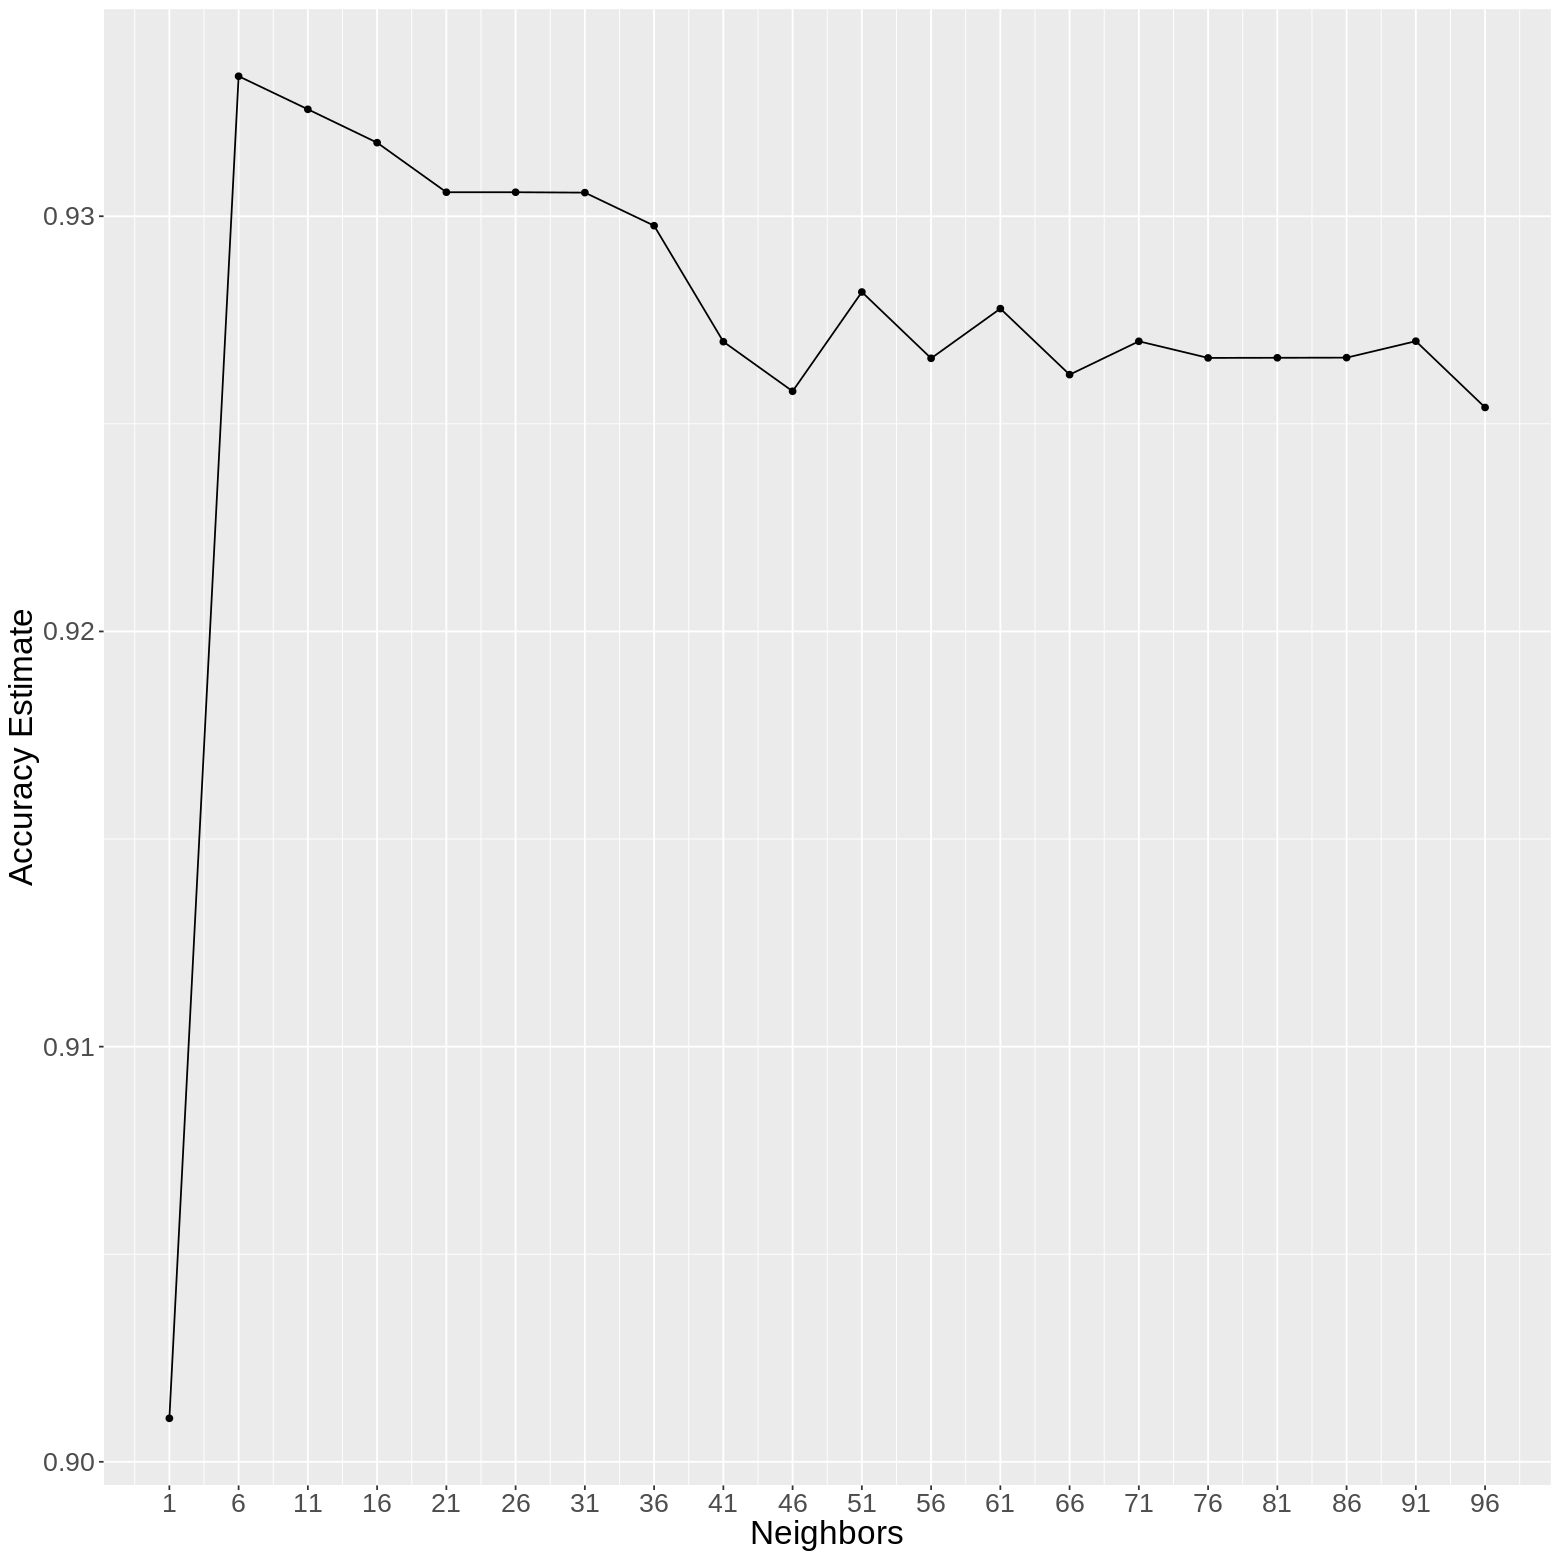

In [38]:
pulsar_recipe <- recipe(Class ~ . , data = pulsar_training) # training data are already scaled

## tuning the parameter
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

# try K with different values:  1 to 100 (stepping by 5)
ks <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

set.seed(123)

knn_results <- workflow() %>%
  add_recipe(pulsar_recipe) %>%
  add_model(knn_tune) %>%
  tune_grid(resamples = vfold, grid = ks) %>%
  collect_metrics() 

accuracies <- knn_results %>%
  filter(.metric == "accuracy")

# accuracy_vs_k 
accuracy_vs_k_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", main = "accuracy VS K") + 
  theme(text = element_text(size = 20)) + 
  scale_x_continuous(breaks = ks$neighbors)
accuracy_vs_k_plot

In [40]:
# get the best k
accuracies[which.max(accuracies$mean), ]
best_k <- accuracies[which.max(accuracies$mean), ]$neighbors

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,binary,0.9333714,10,0.004394289,Preprocessor1_Model02


- the results show that when k (the number of neighbors) = 6, we have the highest accuracy, which is about 0.93.

In [41]:
# build the model using the best k choose from examine the accuracies
set.seed(123)
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") %>%
  set_mode("classification")
pulsar_fit <- workflow() %>%
  add_recipe(pulsar_recipe) %>%
  add_model(pulsar_spec) %>%
  fit(data = pulsar_training)
pulsar_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.06504389
Best kernel: rectangular
Best k: 6

In [42]:
# predict the test set
set.seed(123)
preds <- predict(pulsar_fit, pulsar_test) %>%
  bind_cols(pulsar_test)

# accuracy
metrics <- preds %>% mutate(Class = as.factor(Class)) %>%
  metrics(truth = Class, estimate = .pred_class) %>%
  filter(.metric == "accuracy") 
metrics

# confusion matrix
confusion_mat <- preds %>%
  mutate(Class = as.factor(Class)) %>%
  conf_mat(truth = Class, estimate = .pred_class)
confusion_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9264804


          Truth
Prediction    0    1
         0 4089  329
         1    0   57

#### prediction results:
<blockquote>
The accuracy is quite high: 0.93

    
<blockquote>
However, it might be very bad for the classifier to predict `Class 0` when the true class is `Class 1`:
    - from the confusion matrix we can see that all predictions for Class 0 when true Class is 0 are correct
    - while when true class is 1, about $\frac{329}{329+57} = 85\%$ where misclassified in class 0.



# 7. Discussion: multicollinearity problem

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



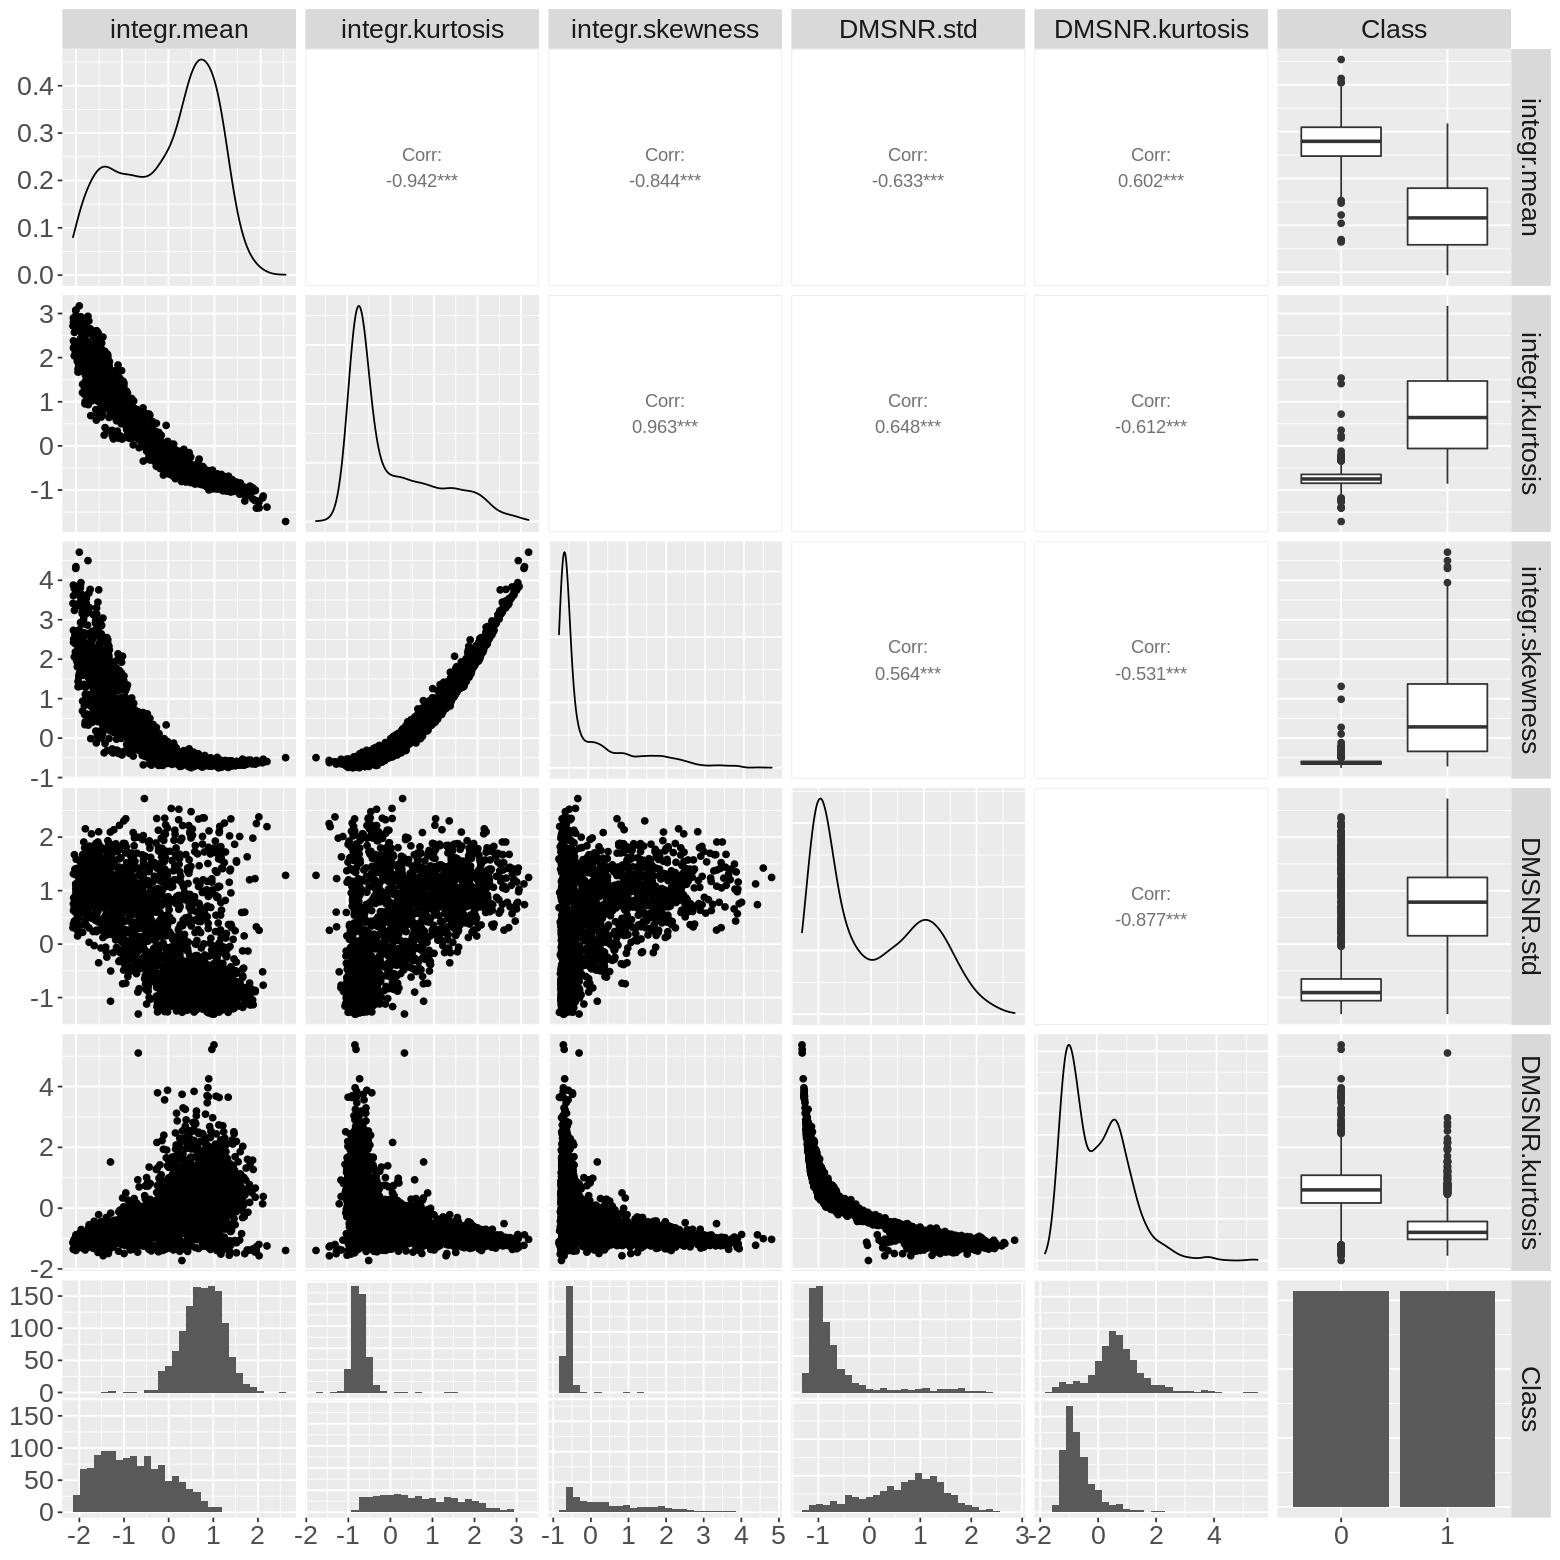

In [44]:
## ggpair plot - check the correlation between each variables in the training set
ggpairs(pulsar_training) + 
  theme(text = element_text(size=20))

There's multicollinearity problem between these predictors we choose since the correlations between each of them are quite high, especially between the `integr.mean`, `integr.kurtosis`, and `integr.skewness` predictors: absolute correlations are higher than 0.7, indicating strong correlation between them. In addition, predictors `DMSNR.std` and `DMSNR.mean` also have strong correlation.

## PCA (Principal Component Analysis)
#### to deal with the multicollinearity problem
#### also help reduce the dimensionality of our model

- reference: https://rpubs.com/maulikpatel/221668

Importance of components:
                          PC1    PC2     PC3     PC4     PC5
Standard deviation     1.7941 1.1458 0.51108 0.42931 0.15139
Proportion of Variance 0.6437 0.2626 0.05224 0.03686 0.00458
Cumulative Proportion  0.6437 0.9063 0.95856 0.99542 1.00000

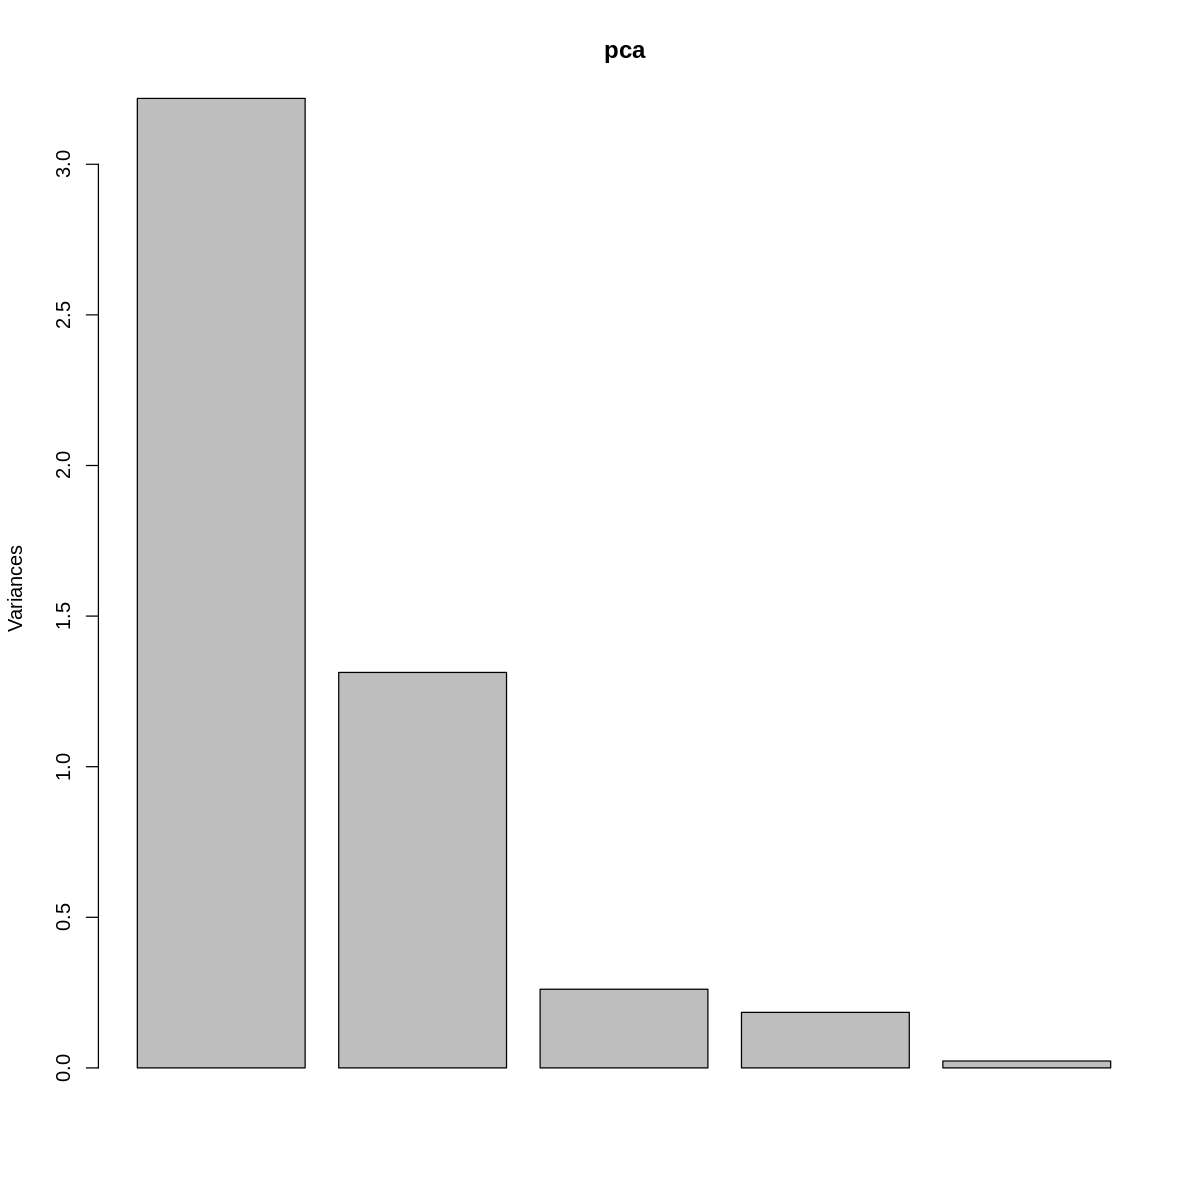

In [47]:
set.seed(123)

subset_pulsar <-  pulsar %>%
  select(integr.mean, integr.kurtosis, integr.skewness, DMSNR.std, DMSNR.kurtosis)  
# use the 5 predictors we choose from correlation matrix

pca <- prcomp(subset_pulsar, scale = TRUE) # scale the dataset
options(repr.plot.width = 10, repr.plot.height = 10) 
screeplot(pca)
summary(pca) # the first two components cover 90% of the variations

In [48]:
# show the contributions of each variable in each principal component respectively
pca$rotation

,PC1,PC2,PC3,PC4,PC5
integr.mean,-0.4612753,-0.3535335,0.75401016,0.05010043,-0.3019897218
integr.kurtosis,0.5221742,0.2805155,0.13120445,0.02513824,-0.7942282912
integr.skewness,0.4989808,0.2568548,0.62903725,0.11154628,0.5262255650
DMSNR.std,0.3843699,-0.5706405,0.02894025,-0.72436283,0.0330162335
DMSNR.kurtosis,-0.3432741,0.6361762,0.13314906,-0.67802207,-0.0004609651


### Visulization for PCA

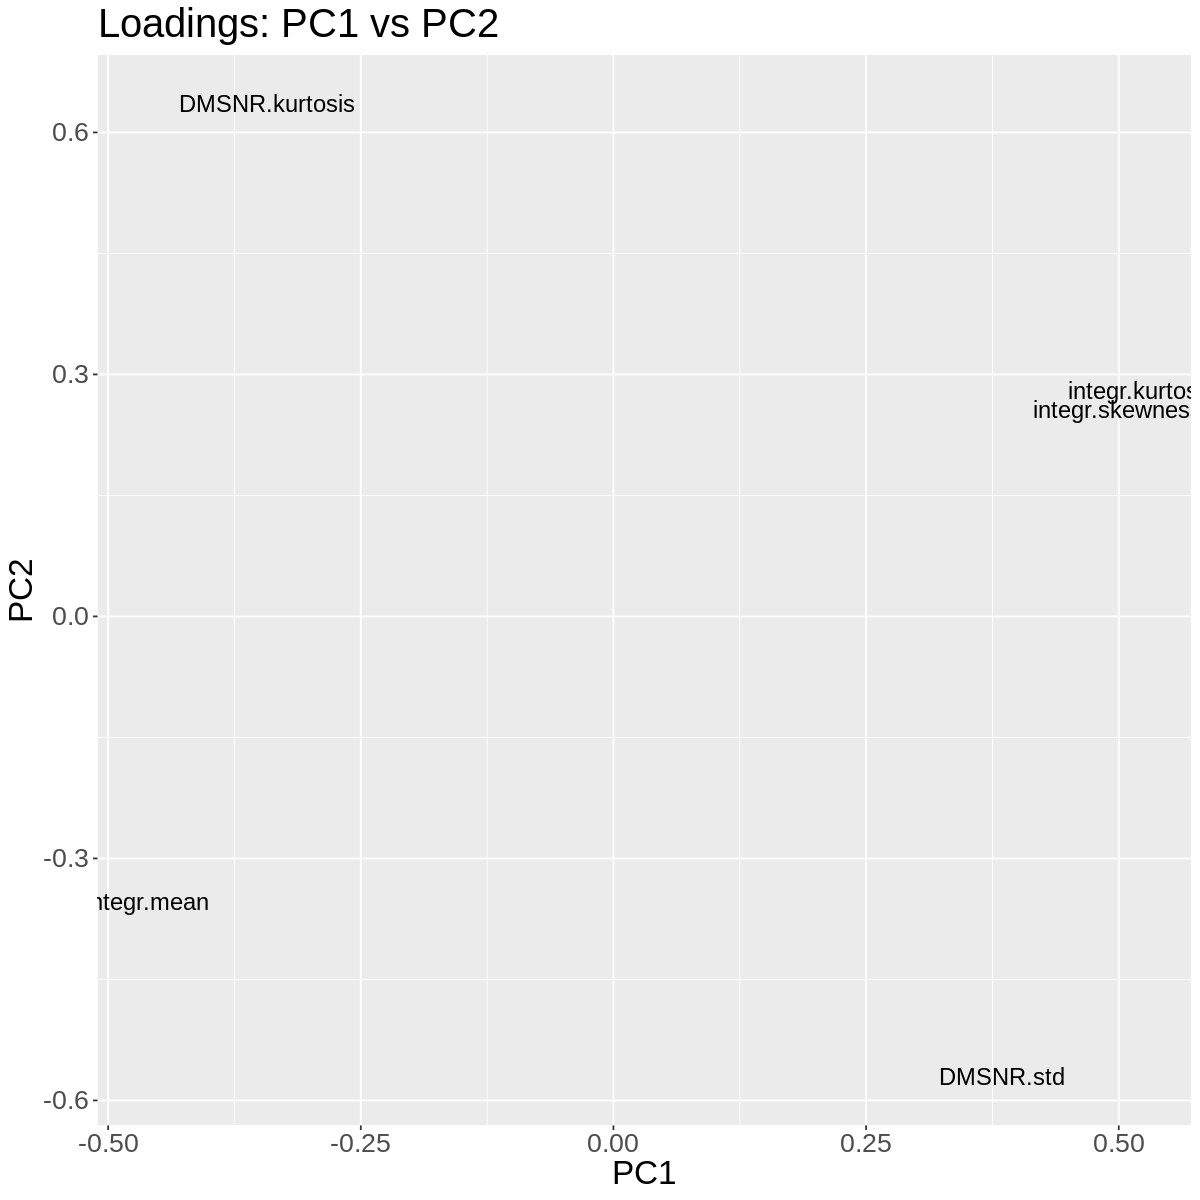

In [58]:
# using the first two principal components in the model
data.frame(pca$rotation[, 1:2], 
           predictors = rownames(pca$rotation)) %>%
  ggplot(aes(PC1, PC2, label = predictors)) + 
  geom_text(cex = 5) + 
  ggtitle("Loadings: PC1 vs PC2") + 
  theme(text = element_text(size=20))

- `integr.mean` has low values on both PC1 and PC2.

- `DMSNR.std` is low on PC2 but high on PC1.

- `DMSNR.kurtosis` is low on PC1 but high on PC2.

In [59]:
# creat matrices for Xs and Y
X = as.matrix(pca$x[ ,1:2])
Y <- as.matrix(pulsar[,dim(pulsar)[2]])

# data partition for train/test sets.
set.seed(123)
trainIndex <- createDataPartition(Y, times=1, p = 0.75, list = F)

# fitting models for 50 different k-values (one for test and one for train set for each K)
test.error = rep(0,50)
for(k in 1:50){
  model.knn.test <- knn(train=X[trainIndex,], test=X[-trainIndex,], cl=Y[trainIndex], k=k)
  test.error[k] <- sum(model.knn.test!=Y[-trainIndex])/length(Y[-trainIndex])
}

In [60]:
which.min(test.error)
test.error[which.min(test.error)]
1 - test.error[which.min(test.error)] # high accuracy score

[1] 40

[1] 0.02391596

[1] 0.976084